# Reinforcement Learning for Portfolio Allocation



<a id='0'></a>
# 1. Problem Definition

We train an algorithm to re-allocate a portfolio of assets once that the market values of the same assets are known for some period in the past. In particular, we implement a deep-Q-learning framework in which:

* the environment is composed by asset market values and portfolio weights, i.e. every state is determined by two components, the correlation matrix of the assets based on a specific time window and the current percentage composition of the portfolio in terms of the assets considered
* the agent is a portfolio manager, i.e. an action is determined by all the instructions for rebalancing the portfolio weights (hold, buy or sell for each of the assets considered) 

As reward function, we set a variation of the sharpe ratio which is made to be asset-specific (instead of a single scalar, we take a vector of average returns, each divided by the overall portfolio volatility). 

<a id='1'></a>
# 2. Loading the data and python packages

Market values of assets is obtained from yahoo-finance (aside: to understand why I chose the adjusted-close as equivalent to crypto prices, see https://help.yahoo.com/kb/SLN28256.html for reference)

<a id='1.1'></a>
## 2.1. Loading the python packages

In [ ]:
# run these lines to get access to your storage space
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# if we have not done it already, let's download yahoo-finance
!pip install yfinance

  Using cached yfinance-0.1.64.tar.gz (26 kB)
     |████████████████████████████████| 6.3 MB 33.0 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=6316a7c5c15a61cca8b0283c31ccfd6f4376a89e945d45b070327974116c60a2
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
# load libraries
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import math
import random

# for plotting
import matplotlib.pyplot as plt
#import matplotlib.pylab as plt

%matplotlib inline

# for the neural network
from keras import layers as ker_lay
from keras import models as ker_mod

In [ ]:
# disable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Loading the Data

In [ ]:
# set some list of stocks to consider, the time interval and frequency of sampling
# let's go with a random list of stocks, during all 2010 and one-day spaced data points 
set_list_00 = ['MMM','GOOGL','AMZN','AXP','AAPL','BAC','KO','COST','DIS','GS','HD','IBM','JNJ','MCD','MSFT','NKE','SBUX','VZ','V','WMT']
set_list_01 = ['GOOGL','AMZN','AAPL','2354.TW','IBM','MSFT','SBUX','V','WMT']
set_list_02 = ['ISP.MI','ENI.MI','UNI.MI','SRS.MI','STM.MI']
set_time = {'start':'2015-01-01','end':'2018-01-01','interval':'1d'}
set_time = {'start':'2018-01-01','end':'2021-10-15','interval':'1d'}

In [ ]:
# first let me download a lot of useless data (it is not the efficient way of doing it - to improve ...)
# then I will drop all unnecessary information - retain only the adjusted close price
# last, I am to reframe the data so that you can use in the following 
dataset = yf.download(' '.join(set_list_00 + set_list_02), group_by='column', **set_time)
dataset = dataset.drop(columns=['Close','Open','High','Low','Volume'])
dataset = dataset.droplevel(0,axis=1)

[*********************100%***********************]  25 of 25 completed


In [ ]:
# shape 
print(dataset.shape)

(978, 25)


In [ ]:
# peek at data
# if you see nans it is because in one same day some stock exchanges 
# might be closed while others are open instead 
pd.set_option('display.width', 100)
dataset.head(3)

,AAPL,AMZN,AXP,BAC,COST,DIS,ENI.MI,GOOGL,GS,HD,IBM,ISP.MI,JNJ,KO,MCD,MMM,MSFT,NKE,SBUX,SRS.MI,STM.MI,UNI.MI,V,VZ,WMT
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,41.248280,1189.010010,93.336876,27.561302,177.262650,108.726059,10.874371,1073.209961,238.379105,172.003632,129.093903,1.903839,126.012619,40.303242,158.214706,209.198395,81.848282,61.186920,53.517845,1.652354,17.681042,3.312117,111.846077,44.937580,91.757294
2018-01-03,41.241093,1204.199951,93.912354,27.469124,179.389954,109.192848,10.945136,1091.520020,236.160080,172.900085,132.642426,1.901074,127.216362,40.214737,157.547989,209.189468,82.229195,61.177292,54.520771,1.694335,18.237473,3.282589,112.959534,44.014153,92.557693
2018-01-04,41.432655,1209.589966,95.474388,27.828621,177.996811,109.144241,11.204613,1095.760010,239.460678,174.272263,135.328934,1.950848,127.207306,40.781136,158.653122,211.923843,82.952927,61.138737,54.725071,1.663269,18.496502,3.346567,113.379539,44.156868,92.641472


<a id='3'></a>
# 3. Environment and Agent classes

<a id='3.1'></a>
## 3.1. Market environment


In [ ]:
class myenvir:
  
  def __init__(self, data, portfolio_choice, reward_def='sharpe'):    
    self.data = data
    self.reward_def = reward_def
    
    # here you choose on which assets to play
    # it is a boolean array
    self.portfolio_choice = portfolio_choice

    # kinda dumb initialization of weights vector
    # anyway when you run the code, you are expected to reset it 
    # as soon as you use the class
    self.weights = np.zeros(self.data.shape[1]) 
    self.weights[self.portfolio_choice] = 1 / np.sum(self.portfolio_choice)


  # calculates the environment state for some time interval 
  # i.e. it determines the covariance matrix of asset prices in the interval
  # and attachs to it the weights vector
  def calc_state(self, t, lookback):

    assert lookback <= t
    market_vals = self.data.iloc[t-lookback:t]
    market_vals = market_vals.pct_change().dropna()

    state = market_vals.cov().values
    state = np.concatenate((state,self.weights.reshape(1,-1)),axis=0)

    return state


  # calculate the reward from your portfolio in some period of time 
  def calc_reward(self, a, action_t, reward_t, returns_ben = None):
    
    data_period = self.data[action_t:reward_t]
    returns = data_period.pct_change().dropna()

    w = self.weights
    arg_choice = np.where(self.portfolio_choice)[0]

    port_ret = returns.mean()[self.portfolio_choice]
    port_vol = np.sqrt(np.dot(w.T, np.dot(returns.cov(), w)))   

    ret_ben = returns_ben.mean()
    vol_ben = returns_ben.var()

    if   self.reward_def=='return' : r = port_ret
    if   self.reward_def=='sharpe' : r = port_ret/port_vol
    elif self.reward_def=='return_ben' : r = port_ret-ret_ben
    #elif self.reward_def=='sharpe_ben' : r = port_ret/port_vol-ret_ben/vol_ben
    elif self.reward_def=='sharpe_ben' : r = (port_ret - ret_ben)/port_vol
    else: return 0
    
    # now, for every asset
    # reward is the quantity you defined if you went for buying the asset
    # reward is the opposite of this quantity if you were selling it
    # if you were holding the asset, reward is negative 
    # and proportional to how much it would have been better to buy or sell 
    for i in range(np.sum(self.portfolio_choice)):
      if   a[i] == 1: r[i] = +r[i] 
      elif a[i] == 2: r[i] = -r[i] 
      else:           r[i] = -np.square(r[i]) 
    return r


  # calculate the return from your portfolio in some period of time
  def calc_return(self, action_t, reward_t):

    # here you build the matrix of percentage returns 
    data_period = self.data[action_t:reward_t]
    returns = data_period.pct_change().dropna()    
    w = self.weights

    # returns an array of weighted percentage returns, one for each day
    return np.dot(returns, w)


  # calculate the new portfolio composition if we were to implement action a
  # this is quite arbitrary a function
  # the idea is that an agent sells the reb_ratio of each of the assets to sell
  # then uses the same capital (which is reb_total) to rebalance
  # i.e. to buy assets to buy, allocating the same capital for each of these
  def update_weights(self, a, reb_ratio=.7):
    
    w = np.copy(self.weights)
    arg_choice = np.where(self.portfolio_choice)[0]

    # find what the agent wants to sell, and what is to buy
    to_sell = np.where(a==2)[0]
    to_buy = np.where(a==1)[0]

    # if both buying and selling vectors are not empty
    # proceed with rebalancing
    reb_total = 0
    if len(to_buy) != 0 and len(to_sell) != 0:
      for i in to_sell :
        w[arg_choice[i]] *= reb_ratio
        reb_total += self.weights[arg_choice[i]] * (1.-reb_ratio) 
      for i in to_buy :
        w[arg_choice[i]] += reb_total / len(to_buy) 

    return w

<a id='3.2'></a>
## 3.2. Agent class

In [ ]:
class myagent:
  
  def __init__(
           self, 
           portfolio_size,
           asset_number,
           is_eval = False
         ):
    
    self.portfolio_size = portfolio_size
    self.asset_number = asset_number
    self.is_eval = is_eval
    self.action_size = 3 # hold, buy, sell 

    # here you initialise the model as you call the class
    self.model = self.build_model()
    self.memory4replay = []

    self.alpha = 0.5
    self.gamma = 0.95
    self.epsilon = 1
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.99
    


  # model determines convenience values for hold, buy, sell for each asset
  # once some state has been provided 
  # this function builds the model every time you initialise this class
  def build_model(self):
    
    inputs = ker_lay.Input(shape=(self.asset_number+1, self.asset_number))    
    x = ker_lay.Flatten()(inputs)
    x = ker_lay.Dense(100, activation='elu')(x)
    x = ker_lay.Dropout(0.5)(x)
    x = ker_lay.Dense(50, activation='elu')(x)
    x = ker_lay.Dropout(0.5)(x)    
    predictions = []
    for i in range(self.portfolio_size):
      asset_dense = ker_lay.Dense(self.action_size, activation='linear')(x)   
      predictions.append(asset_dense)
    
    model = ker_mod.Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam', loss='mse')
    return model
  
  # save the model somewhere 
  def save_model(self, address):
    self.model.save(address)
  
  # load some model which has been saved
  def load_model(self, address): 
    self.model = ker_mod.load_model(address)


  # returns the action based on the state
  # action can be 0 = hold, 1 = buy or 2 = sell
  def calc_action(self, s):    
    # random case of the epsilon-greedy exploration
    if not self.is_eval and random.random() <= self.epsilon:
      a = np.random.randint(self.action_size,size=self.portfolio_size)    
      return a
    # non-random case of the epsilon-greedy exploration
    else: 
      Q_pred = np.squeeze(self.model.predict(np.expand_dims(s,0)))
      a = np.argmax(Q_pred, axis=-1)
      return a


  # update the neural newtork so that it generates a better Q
  def update_Q(self):

    for (s, ss, a, r) in self.memory4replay:

      # build the Q_targ from the current prediction, r and the Bellman eq 
      Q_bell = np.zeros((self.portfolio_size, self.action_size)) 
      Q_pred = np.squeeze(self.model.predict(np.expand_dims(ss,0)))   

      for i in range(self.portfolio_size):
        if   a[i] == 1: Q_bell[i][1] = r[i] + self.gamma * np.max(Q_pred[i][1])
        elif a[i] == 2: Q_bell[i][2] = r[i] + self.gamma * np.max(Q_pred[i][2])
        else:           Q_bell[i][0] = r[i] + self.gamma * np.max(Q_pred[i][0]) 

      Q_targ = Q_bell * self.alpha + Q_pred * (1-self.alpha)
      Q_targ = [qq.reshape(1, -1) for qq in Q_targ]      

      # update the neural newtork 
      self.model.fit(np.expand_dims(s, 0), Q_targ, epochs=1, verbose=0)      
    
    # also, proceed to have epsilon to decay
    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay

<a id='4'></a>
# 4. Training the data

<a id='4.1'></a>
## 4.1. Set parameters, initialise classes

In [ ]:
data_length, asset_number = dataset.shape
portfolio_choice = np.array([dataset.columns[i] in set_list_02 for i in range(asset_number)])
portfolio_size = np.sum(portfolio_choice)

window_size = 100        # determines the state
rebalance_period = 56    # determines the reward
batch_size = 24          # after how many iterations are we resetting Q?
episode_count = 1200     # how many total iterations?

In [ ]:
env =   myenvir(dataset, portfolio_choice, reward_def='return_ben')
agent = myagent(portfolio_size, asset_number)

In [ ]:
# if you want to load some of the saved models, you can go with that 
# agent.load_model('/content/drive/MyDrive/model-sharpe_ben-1440random.ker')

<a id='4.2'></a>
## 4.2. Perform the training!


In [ ]:
agent.is_eval = False

# loop on the training episodes 
for e in range(episode_count): 
  
  # choose a random moment to work with
  t_start = np.random.randint(window_size, data_length-rebalance_period-1)
  t_end = t_start+rebalance_period

  # set weights randomly at the beginning
  weights = np.random.normal(0, 1, size = (np.sum(portfolio_choice), ))
  weights += np.abs(np.min(weights))
  weights /= np.sum(weights)
  env.weights = np.zeros(asset_number) 
  env.weights[portfolio_choice] = weights

  # or maybe all equal weights 
  #weights = np.ones(portfolio_size) / portfolio_size
  #env.weights = np.zeros(asset_number) 
  #env.weights[portfolio_choice] = weights

  # now calculate the return in ben's game i.e. by taking no action
  returns_ben = env.calc_return(t_start, t_end)

  # and which one is the return if we let rob play instead
  s = env.calc_state(t_start, window_size)
  a = agent.calc_action(s)

  env.weights = env.update_weights(a)
  returns_rob = env.calc_return(t_start, t_end)

  # show-time! let us see the performances of rob and ben
  print('episode '+str(e+1)+'/'+str(episode_count)+' - epsilon', agent.epsilon) 
  #print('weights ', {env.data.columns[portfolio_choice][k]:env.weights[portfolio_choice][k] for k in range(portfolio_size)})

  plt.figure(figsize = (12, 2))
  plt.plot(np.array(returns_rob).cumsum(), color = 'black', ls = '-')
  plt.plot(np.array(returns_ben).cumsum(), color = 'grey', ls = '--')
  plt.show()
  
  plt.figure(figsize = (12, 2))
  plt.bar(np.arange(portfolio_size), a, color = 'grey', alpha = 0.25)
  plt.xticks(np.arange(portfolio_size), env.data.columns[portfolio_choice], rotation='vertical')
  plt.show()

  # finally, let's calculate the reward for rob
  r = env.calc_reward(a, t_start, t_end, returns_ben) 
  ss = env.calc_state(t_end, window_size)

  # and let rob write it down, possibly learn from it!
  agent.memory4replay.append((s, ss, a, r))   
  if len(agent.memory4replay) >= batch_size:
    agent.update_Q()
    agent.memory4replay = []

<a id='5'></a>
# 5. Robo-manager at work

<a id='5.1'></a>
## 5.1. A simple test 

test run - epsilon 0.6050060671375365


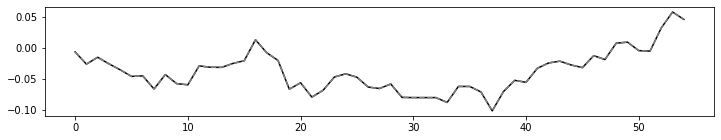

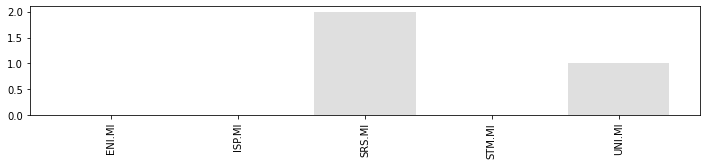

reward detail
ENI.MI   -4.564953e-06
ISP.MI   -2.483167e-07
SRS.MI   -2.284272e-04
STM.MI   -1.129165e-06
UNI.MI    1.647646e-03
dtype: float64


In [ ]:
agent.is_eval = True

# take a random moment in time 
t_start = np.random.randint(window_size, data_length-rebalance_period-1)
t_end = t_start+rebalance_period

# set weights randomly at the beginning
weights = np.random.normal(0, 1, size = (np.sum(portfolio_choice), ))
weights += np.abs(np.min(weights))
weights /= np.sum(weights)
env.weights = np.zeros(asset_number) 
env.weights[portfolio_choice] = weights

# now calculate the return in ben's game i.e. by taking no action
returns_ben = env.calc_return(t_start, t_end)

# and which one is the return if we let rob play instead
s = env.calc_state(t_start, window_size)
a = agent.calc_action(s)

env.weights = env.update_weights(a)
returns_rob = env.calc_return(t_start, t_end)

# show-time! let us see the performances of rob and ben
print('test run - epsilon', agent.epsilon)  

plt.figure(figsize = (12, 2))
plt.plot(np.array(returns_rob).cumsum(), color = 'black', ls = '-')
plt.plot(np.array(returns_ben).cumsum(), color = 'grey', ls = '--')
plt.show()
  
plt.figure(figsize = (12, 2))
plt.bar(np.arange(portfolio_size), a, color = 'grey', alpha = 0.25)
plt.xticks(np.arange(portfolio_size), env.data.columns[portfolio_choice], rotation='vertical')
plt.show()

r = env.calc_reward(a, t_start, t_end, returns_ben)
print('reward detail' )
print(r)

In [ ]:
from statsmodels import api as stm_api
from statsmodels import regression as stm_reg

def print_stats(result, benchmark):

    port_ret = np.mean(np.array(result))
    port_vol = np.std(np.array(result))
    port_sha = port_ret / port_vol * np.sqrt(rebalance_period)

    y = result
    x = stm_api.add_constant(benchmark)
    model = stm_reg.linear_model.OLS(y, x).fit()    
    alpha = model.params[0]
    beta = model.params[1]
    
    return np.round(np.array([port_ret, port_vol, port_sha, alpha, beta]), 4).tolist()

In [ ]:
print('EQUAL', print_stats(returns_ben, returns_ben))
print('RL AGENT', print_stats(returns_rob, returns_ben))

EQUAL [0.0008, 0.0171, 0.364, -0.0, 1.0]
RL AGENT [0.0008, 0.0171, 0.364, -0.0, 1.0]


<a id='5.2'></a>
## 5.2. A simple prediction 

prediction - epsilon 0.6050060671375365
optimal weights  {'ENI.MI': 0.2, 'ISP.MI': 0.2, 'SRS.MI': 0.2, 'STM.MI': 0.2, 'UNI.MI': 0.2}


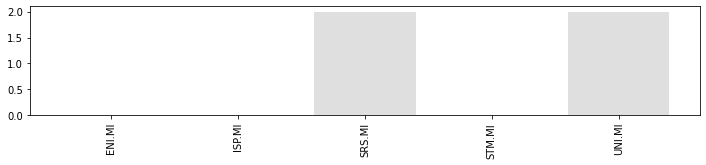

In [ ]:
agent.is_eval = True

# another possibility: take the last time interval
t_start = data_length

# and equal weights 
weights = np.ones(portfolio_size) / portfolio_size
env.weights = np.zeros(asset_number) 
env.weights[portfolio_choice] = weights

# and which one is the return if we let rob play instead
s = env.calc_state(t_start, window_size)
a = agent.calc_action(s)

# here you try to assess the optimal portfolio allocation for this moment
to_sell = np.where(a==2)[0]
to_buy = np.where(a==1)[0]

if len(to_buy) != 0 and len(to_sell) != 0:
  kk = 0
  aa = +a 
  while np.all(aa == a) and kk < 30: 
    env.weights = env.update_weights(aa)
    ss = env.calc_state(t_start, window_size)
    aa = agent.calc_action(ss)
    kk += 1


# show-time! let us see the performances of rob and ben
print('prediction - epsilon', agent.epsilon)  
print('optimal weights ', {env.data.columns[portfolio_choice][k]:env.weights[portfolio_choice][k] for k in range(portfolio_size)})

plt.figure(figsize = (12, 2))
plt.bar(np.arange(portfolio_size), a, color = 'grey', alpha = 0.25)
plt.xticks(np.arange(portfolio_size), env.data.columns[portfolio_choice], rotation='vertical')
plt.show()

 sharpe \\
420 random : buy ISP, STM, UNI - sell ENI, SRS \\
360 random : buy ENI, UNI - sell ISP, SRS \\
720 random : buy STM, UNI - sell SRS  --- looks like the average of all results \\
360 uniform : buy ISP, STM - sell SRS \\
360 random : buy SRS, STM, UNI - sell ENI \\
360 random & 360 uniform: buy ISP, STM, UNI - sell SRS \\
 \\

 sharpe_ben & account for variance \\
720 random : buy STM, UNI - sell ENI, ISP, SRS \\
720 random : buy ISP, STM, UNI - sell ENI, SRS \\
720 random : buy STM, UNI - sell ENI, ISP, SRS \\
720 random : buy ISP, STM, UNI - sell ENI, SRS \\
1440 random : buy STM, UNI - sell ENI, SRS  [model-sharpe_ben-1440random.ker] \\
1200 random : buy ISP, STM, UNI - sell ENI, SRS  [model-sharpe_ben-1200random.ker] \\
 \\

return_ben & account for variance \\
1200 random : sell SRS, UNI ... 

In [ ]:
# if you want to save the saved model, you can go with that 
# agent.save_model('/content/drive/MyDrive/model-return_ben-1200random.ker')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model-return_ben-1200random.ker/assets
